# Task 0

In [1]:
import tensorflow as tf
tf.config.gpu.set_per_process_memory_fraction(0.3)
tf.config.gpu.set_per_process_memory_growth(True)

In [1]:
##image loader

import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def path_loader(fold1, fold2, data_path):
    #Creating data path
    image_data_path = os.path.join(data_path, fold1)   
    mask_data_path = os.path.join(data_path, fold2)
    images = []
    masks = []
    #Listing all file names in the path
    for root, dirs, files in os.walk(image_data_path):
        for name in files:
            images.append(os.path.join(image_data_path,name))
    for root2, dirs2, files2 in os.walk(mask_data_path):
        for name2 in files2:
            masks.append(os.path.join(mask_data_path,name2))
    return images, masks
    

# reading and resizing the training images with their corresponding labels
def get_train_data_shuffled(images, masks, p):
    
    c = list(zip(images, masks))

    shuffle(c)

    images, masks = zip(*c)
    
    train_x, test_x, train_y, test_y = train_test_split(images,masks,test_size = p)

    return train_x, test_x, train_y, test_y 

def data_loader(fold1, fold2, data_path, p,img_h, img_w):
    
    images, masks = path_loader(fold1, fold2, data_path)
    train_x, test_x, train_y, test_y = get_train_data_shuffled(images, masks, p)
    
    train_img = []
    train_mask = []
    test_img = []
    test_mask = []
    len(train_x)
    for i in range(len(train_x)):
        image_name = train_x[i]
        img = imread(image_name, as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_img.append([np.array(img)]) 

        if i % 50 == 0:
             print('Reading: {0}/{1}  of train images'.format(i, len(train_x)))
    for j in range(len(train_y)):
        mask_name = train_y[j]
        mask = imread(mask_name, as_grey=True)
        mask = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        train_mask.append([np.array(mask)])
        
    for i in range(len(test_x)):
        image_name = test_x[i]
        img = imread(image_name, as_grey=True)
        img = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_img.append([np.array(img)]) 

        if i % 50 == 0:
             print('Reading: {0}/{1}  of test images'.format(i, len(test_x)))
                
    for j in range(len(test_y)):
        mask_name = test_y[j]
        mask = imread(mask_name, as_grey=True)
        mask = resize(img, (img_h, img_w), anti_aliasing = True).astype('float32')
        test_mask.append([np.array(mask)])        
        
 
    return train_img, train_mask, test_img, test_mask

# Instantiating images and labels for the model.
def get_train_test_data(fold1, fold2, data_path, p,img_h, img_w):
    
    train_img, train_mask, test_img, test_mask = data_loader(fold1, fold2, data_path, p,img_h, img_w)

    Train_Img = np.zeros((len(train_img), img_h, img_w), dtype = np.float32)
    Test_Img = np.zeros((len(test_img), img_h, img_w), dtype = np.float32)

    Train_Label = np.zeros((len(train_mask),img_h, img_w), dtype = np.int32)
    Test_Label = np.zeros((len(test_mask),img_h, img_w), dtype = np.int32)

    for i in range(len(train_img)):
        Train_Img[i] = train_img[i][0]
        Train_Label[i] = train_mask[i][0]

    Train_Img = np.expand_dims(Train_Img, axis = 3)  
    Train_Label = np.expand_dims(Train_Label, axis = 3) 

    for j in range(len(test_img)):
        Test_Img[j] = test_img[j][0]
        Test_Label[j] = test_mask[j][0]

    Test_Img = np.expand_dims(Test_Img, axis = 3)
    Test_Label = np.expand_dims(Test_Label, axis = 3)
    print(Train_Img.shape)
    print(Test_Img.shape)

    return Train_Img, Train_Label, Test_Img, Test_Label


In [2]:
##Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

def DataAugmentation(rotation_range,width_shift,height_shift_range,rescale,horizontal_flip):
    
    #Train data
    train_datagen = ImageDataGenerator(rotation_range = rotation_range, width_shift_range = width_shift, height_shift_range=height_shift_range,
                                       horizontal_flip = horizontal_flip, rescale = rescale)
   
    #Val data
    val_datagen = ImageDataGenerator(rescale = rescale)
 
    
    
    return train_datagen, val_datagen 

In [3]:
##similarity metrics
from sklearn.metrics import recall_score, precision_score
from scipy.spatial.distance import dice


def similarity(metric,img1,img2):

    if metric == 'recall':
        m = recall_score(img1,img2)
    elif metric == 'precision':
        m = precision_score(img1,img2)
        
    return m

In [4]:
from tensorflow.keras import backend as K
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [5]:
##model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Input, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import MaxPooling2D

def u_net(Base,img_height, img_width, img_ch, batchNormalization, SDRate, spatial_dropout):
    inputs = Input((img_height, img_width, img_ch))
    #model = Sequential(img_ch,img_width,img_height, batchNormalization, spatial_dropout, SDRate, dropout, dropoutRate)
    ## Contraction
    # Conv Block 1
    
    c1 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
    
     #Add batch Normalization
    if batchNormalization:
        c1 = BatchNormalization(axis=-1)(c1)
    
    a1 = Activation('relu')(c1)
    
    #Add spatial Dropout
    if spatial_dropout:
        a1 = SpatialDropout2D(SDRate)(a1)
        
    c2 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a1)
    
     #Add batch Normalization
    if batchNormalization:
        c2 = BatchNormalization(axis=-1)(c2)
    
    a2 = Activation('relu')(c2)
    
    #Add spatial Dropout
    if spatial_dropout:
        a2 = SpatialDropout2D(SDRate)(a2)
        
    m1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a2)
        
    # Conv Block 2
    c3 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(m1)
    
     #Add batch Normalization
    if batchNormalization:
        c3 = BatchNormalization(axis=-1)(c3)
    
    a3 = Activation('relu')(c3)
    
    #Add spatial Dropout
    if spatial_dropout:
        a3 = SpatialDropout2D(SDRate)(a3)
    
    c4 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a3)
    
     #Add batch Normalization
    if batchNormalization:
        c4 = BatchNormalization(axis=-1)(c4)
    
    a4 = Activation('relu')(c4)
    
    #Add spatial Dropout
    if spatial_dropout:
        a4 = SpatialDropout2D(SDRate)(a4)
    
    m2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a4)
    
    # Conv Block 3
    c5 = Conv2D(filters=Base*4, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m2)
    
     #Add batch Normalization
    if batchNormalization:
        c5 = BatchNormalization(axis=-1)(c5)
    
    a5 = Activation('relu')(c5)
    
    #Add spatial Dropout
    if spatial_dropout:
        a5 = SpatialDropout2D(SDRate)(a5)
        
    c6 = Conv2D(filters=Base*4,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a5)
    
     #Add batch Normalization
    if batchNormalization:
          c6 = BatchNormalization(axis=-1)(c6)
    
    a6 = Activation('relu')(c6)
    
    #Add spatial Dropout
    if spatial_dropout:
        a6 = SpatialDropout2D(SDRate)(a6)
        
    m3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a6)
    
    # Conv Block 4
    c7 = Conv2D(filters=Base*8, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m3)
    
     #Add batch Normalization
    if batchNormalization:
        c7 = BatchNormalization(axis=-1)(c7)
    
    a7 = Activation('relu')(c7)
    
    #Add spatial Dropout
    if spatial_dropout:
        a7 = SpatialDropout2D(SDRate)(a7)
        
    c8 = Conv2D(filters=Base*8,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a7)
    
     #Add batch Normalization
    if batchNormalization:
        c8 = BatchNormalization(axis=-1)(c8)
    
    a8 = Activation('relu')(c8)
    
    #Add spatial Dropout
    if spatial_dropout:
        a8 = SpatialDropout2D(SDRate)(a8)
        
    m4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a8)
    
    ##Bottleneck
    # Conv Layer
    c9 = Conv2D(filters=Base*16, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m4)
    
     #Add batch Normalization
    if batchNormalization:
        c9 = BatchNormalization(axis=-1)(c9)
    
    a9 = Activation('relu')(c9)
    
    #Add spatial Dropout
    if spatial_dropout:
        a9 = SpatialDropout2D(SDRate)(a9)
        
    ##Expansion
    #Conv Block 1
    c10 = Conv2DTranspose(filters=Base*8,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a9)
    c10 = concatenate([a8,c10])
    
    c11 = Conv2D(filters=Base*8,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c10)
    
     #Add batch Normalization
    if batchNormalization:
        c11 = BatchNormalization(axis=-1)(c11)
    
    a10 = Activation('relu')(c11)
    
    #Add spatial Dropout
    if spatial_dropout:
        a10 = SpatialDropout2D(SDRate)(a10)
        
    c12 = Conv2D(filters=Base*8, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(a10)
    
     #Add batch Normalization
    if batchNormalization:
        c12 = BatchNormalization(axis=-1)(c12)
    
    a11 = Activation('relu')(c12)
    
    #Add spatial Dropout
    if spatial_dropout:
        a11 = SpatialDropout2D(SDRate)(a11)
        
    
    #Conv Block 2
    c13 = Conv2DTranspose(filters=Base*4,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a11)
    c13 = concatenate([a6,c13])
    
    c14 = Conv2D(filters=Base*4,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c13)
    
     #Add batch Normalization
    if batchNormalization:
        c14 = BatchNormalization(axis=-1)(c14)
    
    a12 = Activation('relu')(c14)
    
    #Add spatial Dropout
    if spatial_dropout:
        a12 = SpatialDropout2D(SDRate)(a12)
        
    c15 = Conv2D(filters=Base*4, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(a12)
    
     #Add batch Normalization
    if batchNormalization:
        c15 = BatchNormalization(axis=-1)(c15)
    
    a13 = Activation('relu')(c15)
    
    #Add spatial Dropout
    if spatial_dropout:
        a13 = SpatialDropout2D(SDRate)(a13)
        
    
    #Conv Block 3
    c16 = Conv2DTranspose(filters=Base*2,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a13)
    c16 = concatenate([a4,c16])
    
    c17 = Conv2D(filters=Base*2, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(c16)
    
     #Add batch Normalization
    if batchNormalization:
        c17 = BatchNormalization(axis=-1)(c17)
    
    a14 = Activation('relu')(c17)
    
    #Add spatial Dropout
    if spatial_dropout:
        a14 = SpatialDropout2D(SDRate)(a14)
        
    c18 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a14)
    
     #Add batch Normalization
    if batchNormalization:
        c18 = BatchNormalization(axis=-1)(c18)
    
    a15 = Activation('relu')(c18)
    
    #Add spatial Dropout
    if spatial_dropout:
        a15 = SpatialDropout2D(SDRate)(a15)
        
    
    #Conv Block 4
    c19 = Conv2DTranspose(filters=Base,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a15)
    c19 = concatenate([a2,c19])
    
    c20 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c19)
    
     #Add batch Normalization
    if batchNormalization:
        c20 = BatchNormalization(axis=-1)(c20)
    
    a16 = Activation('relu')(c20)
    
    #Add spatial Dropout
    if spatial_dropout:
        a16 = SpatialDropout2D(SDRate)(a16)
        
    c21 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a16)
    
     #Add batch Normalization
    if batchNormalization:
        c21 = BatchNormalization(axis=-1)(c21)
    
    a17 = Activation('relu')(c21)
    
    #final layer
    c22 = Conv2D(1, kernel_size=(3,3), strides=(1,1), padding='same')(a17)
    a18 = Activation('sigmoid')(c22)
    
    model = Model(inputs,a18)
    
    model.summary()
    return model

In [6]:
##model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, Input, concatenate, Conv2DTranspose
from tensorflow.keras.layers import Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import MaxPooling2D

def u_net_3labels(Base,img_height, img_width, img_ch, batchNormalization, SDRate, spatial_dropout):
    print("building model")
    inputs = Input((img_height, img_width, img_ch))
    #model = Sequential(img_ch,img_width,img_height, batchNormalization, spatial_dropout, SDRate, dropout, dropoutRate)
    ## Contraction
    # Conv Block 1
    
    c1 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
    
     #Add batch Normalization
    if batchNormalization:
        c1 = BatchNormalization(axis=-1)(c1)
    
    a1 = Activation('relu')(c1)
    
    #Add spatial Dropout
    if spatial_dropout:
        a1 = SpatialDropout2D(SDRate)(a1)
        
    c2 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a1)
    
     #Add batch Normalization
    if batchNormalization:
        c2 = BatchNormalization(axis=-1)(c2)
    
    a2 = Activation('relu')(c2)
    
    #Add spatial Dropout
    if spatial_dropout:
        a2 = SpatialDropout2D(SDRate)(a2)
        
    m1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a2)
        
    # Conv Block 2
    c3 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(m1)
    
     #Add batch Normalization
    if batchNormalization:
        c3 = BatchNormalization(axis=-1)(c3)
    
    a3 = Activation('relu')(c3)
    
    #Add spatial Dropout
    if spatial_dropout:
        a3 = SpatialDropout2D(SDRate)(a3)
    
    c4 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a3)
    
     #Add batch Normalization
    if batchNormalization:
        c4 = BatchNormalization(axis=-1)(c4)
    
    a4 = Activation('relu')(c4)
    
    #Add spatial Dropout
    if spatial_dropout:
        a4 = SpatialDropout2D(SDRate)(a4)
    
    m2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a4)
    
    # Conv Block 3
    c5 = Conv2D(filters=Base*4, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m2)
    
     #Add batch Normalization
    if batchNormalization:
        c5 = BatchNormalization(axis=-1)(c5)
    
    a5 = Activation('relu')(c5)
    
    #Add spatial Dropout
    if spatial_dropout:
        a5 = SpatialDropout2D(SDRate)(a5)
        
    c6 = Conv2D(filters=Base*4,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a5)
    
     #Add batch Normalization
    if batchNormalization:
          c6 = BatchNormalization(axis=-1)(c6)
    
    a6 = Activation('relu')(c6)
    
    #Add spatial Dropout
    if spatial_dropout:
        a6 = SpatialDropout2D(SDRate)(a6)
        
    m3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a6)
    
    # Conv Block 4
    c7 = Conv2D(filters=Base*8, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m3)
    
     #Add batch Normalization
    if batchNormalization:
        c7 = BatchNormalization(axis=-1)(c7)
    
    a7 = Activation('relu')(c7)
    
    #Add spatial Dropout
    if spatial_dropout:
        a7 = SpatialDropout2D(SDRate)(a7)
        
    c8 = Conv2D(filters=Base*8,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a7)
    
     #Add batch Normalization
    if batchNormalization:
        c8 = BatchNormalization(axis=-1)(c8)
    
    a8 = Activation('relu')(c8)
    
    #Add spatial Dropout
    if spatial_dropout:
        a8 = SpatialDropout2D(SDRate)(a8)
        
    m4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(a8)
    
    ##Bottleneck
    # Conv Layer
    c9 = Conv2D(filters=Base*16, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(m4)
    
     #Add batch Normalization
    if batchNormalization:
        c9 = BatchNormalization(axis=-1)(c9)
    
    a9 = Activation('relu')(c9)
    
    #Add spatial Dropout
    if spatial_dropout:
        a9 = SpatialDropout2D(SDRate)(a9)
        
    ##Expansion
    #Conv Block 1
    c10 = Conv2DTranspose(filters=Base*8,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a9)
    c10 = concatenate([a8,c10])
    
    c11 = Conv2D(filters=Base*8,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c10)
    
     #Add batch Normalization
    if batchNormalization:
        c11 = BatchNormalization(axis=-1)(c11)
    
    a10 = Activation('relu')(c11)
    
    #Add spatial Dropout
    if spatial_dropout:
        a10 = SpatialDropout2D(SDRate)(a10)
        
    c12 = Conv2D(filters=Base*8, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(a10)
    
     #Add batch Normalization
    if batchNormalization:
        c12 = BatchNormalization(axis=-1)(c12)
    
    a11 = Activation('relu')(c12)
    
    #Add spatial Dropout
    if spatial_dropout:
        a11 = SpatialDropout2D(SDRate)(a11)
        
    
    #Conv Block 2
    c13 = Conv2DTranspose(filters=Base*4,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a11)
    c13 = concatenate([a6,c13])
    
    c14 = Conv2D(filters=Base*4,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c13)
    
     #Add batch Normalization
    if batchNormalization:
        c14 = BatchNormalization(axis=-1)(c14)
    
    a12 = Activation('relu')(c14)
    
    #Add spatial Dropout
    if spatial_dropout:
        a12 = SpatialDropout2D(SDRate)(a12)
        
    c15 = Conv2D(filters=Base*4, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(a12)
    
     #Add batch Normalization
    if batchNormalization:
        c15 = BatchNormalization(axis=-1)(c15)
    
    a13 = Activation('relu')(c15)
    
    #Add spatial Dropout
    if spatial_dropout:
        a13 = SpatialDropout2D(SDRate)(a13)
        
    
    #Conv Block 3
    c16 = Conv2DTranspose(filters=Base*2,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a13)
    c16 = concatenate([a4,c16])
    
    c17 = Conv2D(filters=Base*2, 
                     kernel_size=(3,3), strides=(1,1), padding='same')(c16)
    
     #Add batch Normalization
    if batchNormalization:
        c17 = BatchNormalization(axis=-1)(c17)
    
    a14 = Activation('relu')(c17)
    
    #Add spatial Dropout
    if spatial_dropout:
        a14 = SpatialDropout2D(SDRate)(a14)
        
    c18 = Conv2D(filters=Base*2,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a14)
    
     #Add batch Normalization
    if batchNormalization:
        c18 = BatchNormalization(axis=-1)(c18)
    
    a15 = Activation('relu')(c18)
    
    #Add spatial Dropout
    if spatial_dropout:
        a15 = SpatialDropout2D(SDRate)(a15)
        
    
    #Conv Block 4
    c19 = Conv2DTranspose(filters=Base,
                     kernel_size=(2,2), strides=(2,2), padding='same')(a15)
    c19 = concatenate([a2,c19])
    
    c20 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(c19)
    
     #Add batch Normalization
    if batchNormalization:
        c20 = BatchNormalization(axis=-1)(c20)
    
    a16 = Activation('relu')(c20)
    
    #Add spatial Dropout
    if spatial_dropout:
        a16 = SpatialDropout2D(SDRate)(a16)
        
    c21 = Conv2D(filters=Base,
                     kernel_size=(3,3), strides=(1,1), padding='same')(a16)
    
     #Add batch Normalization
    if batchNormalization:
        c21 = BatchNormalization(axis=-1)(c21)
    
    a17 = Activation('relu')(c21)
    
    #final layer
    c22 = Conv2D(3, kernel_size=(3,3), strides=(1,1), padding='same')(a17)
    a18 = Activation('softmax')(c22)
    
    model = Model(inputs,a18)
    
    model.summary()
    return model

In [7]:
##plotter
import matplotlib.pyplot as plt
def plotter(History):
    #Training vs Validation Learning loss 
    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
             np.min(History.history["val_loss"]),
             marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend(); 
    
    #Train and test accuracy plot
    plt.figure(figsize=(4,4))
    plt.title("Dice Score Curve")
    plt.plot(History.history["dice_coef"], label="dice_coef")
    plt.plot(History.history["val_dice_coef"], label="val_dice_coef")
    #plt.plot(History.history["categorical_accuracy"], label="categorical_accuracy")
    #plt.plot(History.history["val_categorical_accuracy"], label="val_categorical_accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coef')
    plt.legend(); 


# Task 1a/b & 2 & 3 & 4

Reading: 0/187  of train images
Reading: 50/187  of train images
Reading: 100/187  of train images
Reading: 150/187  of train images
Reading: 0/47  of test images
(187, 256, 256, 1)
(47, 256, 256, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________

Epoch 1/150
187/187 [==============================] - 3s 13ms/sample - loss: -0.0196 - dice_coef: 0.0196 - val_loss: -0.0207 - val_dice_coef: 0.0207
Epoch 2/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.0203 - dice_coef: 0.0204 - val_loss: -0.0212 - val_dice_coef: 0.0212
Epoch 3/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.0214 - dice_coef: 0.0214 - val_loss: -0.0226 - val_dice_coef: 0.0226
Epoch 4/150
187/187 [==============================] - 1s 5ms/sample - loss: -0.0239 - dice_coef: 0.0240 - val_loss: -0.0271 - val_dice_coef: 0.0271
Epoch 5/150
187/187 [==============================] - 1s 5ms/sample - loss: -0.0259 - dice_coef: 0.0259 - val_loss: -0.0282 - val_dice_coef: 0.0282
Epoch 6/150
187/187 [==============================] - 1s 5ms/sample - loss: -0.0279 - dice_coef: 0.0280 - val_loss: -0.0339 - val_dice_coef: 0.0339
Epoch 7/150
187/187 [==============================] - 1s 5ms/sample - loss: -0.0323 - dice_coef: 0.0323 

Epoch 56/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9193 - dice_coef: 0.9205 - val_loss: -0.1863 - val_dice_coef: 0.1863
Epoch 57/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9502 - dice_coef: 0.9506 - val_loss: -0.1998 - val_dice_coef: 0.1997
Epoch 58/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9470 - dice_coef: 0.9474 - val_loss: -0.1867 - val_dice_coef: 0.1867
Epoch 59/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9495 - dice_coef: 0.9495 - val_loss: -0.2026 - val_dice_coef: 0.2026
Epoch 60/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.8314 - dice_coef: 0.8344 - val_loss: -0.2043 - val_dice_coef: 0.2043
Epoch 61/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9455 - dice_coef: 0.9451 - val_loss: -0.1877 - val_dice_coef: 0.1877
Epoch 62/150
187/187 [==============================] - 1s 6ms/sample - loss: -0.9558 - dice_coef: 0

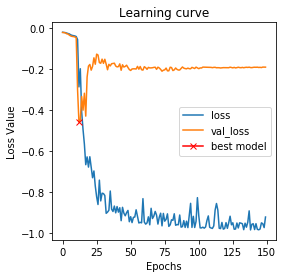

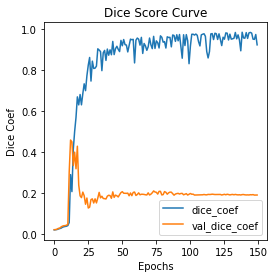

In [10]:
from tensorflow.keras.optimizers import SGD, Adam
from scipy.spatial.distance import dice
image_size = 256
img_ch = 1
batch_size = 8
LR = 0.0001
SDRate = 0.5
spatial_dropout = True
epochs = 150
p = 0.2 #percentage of training and test data
path = '/Lab1/Lab3/X_ray/'
fold1 = 'Image'
fold2 = 'Mask'
task = '2b' 

if task == '4':
    
    base  = 32
    batch_normalization = True
    rotation_range = 10
    width_shift = 0.1
    height_shift = 0.1
    rescale = 0.2
    horizontal_flip = True
    
    train_datagen, val_datagen = DataAugmentation(rotation_range,width_shift,height_shift,rescale,horizontal_flip)
    train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
    model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
    model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef])
    #Fit the data into the model
    History = model.fit_generator(train_datagen.flow(train_img, train_mask,batch_size = batch_size), validation_data = val_datagen.flow(test_img, test_mask), epochs = epochs, verbose = 1)        

else:
    if task == '1a':
        base = 16
        batch_normalization = True
        train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p, image_size, image_size)
        model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
        model.compile(optimizer = Adam(lr=LR), loss = 'binary_crossentropy', metrics =[dice_coef])

    elif task == '1b':
        base = 16
        batch_normalization = True
        train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
        model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
        model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef])

    elif task == '2a':
        base = 16
        batch_normalization = False
        train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
        model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
        model.compile(optimizer = Adam(lr=LR), loss = 'binary_crossentropy', metrics =[dice_coef])

    elif task == '2b':
        base = 16
        batch_normalization = False
        train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
        model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
        model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef])

    elif task == '3':
        base = 32
        batch_normalization = True
        train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
        model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)
        model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef])
    
    print('lol')
    History = model.fit(train_img, train_mask, epochs = epochs, batch_size = batch_size, verbose = 1,
                        validation_data = (test_img,test_mask))
    

plotter(History)




In [8]:
! ls '/Lab1/Lab3/CT'

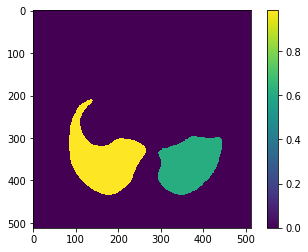

In [11]:
image = plt.imread('/Lab1/Lab3/CT/Mask/Im127_128_Mask.png')
plt.figure()
plt.imshow(image)
plt.colorbar()

### Task 5a

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

base = 16
image_size = 256
img_ch = 1
batch_size =8
LR = 0.0001
SDRate = 0.5
batch_normalization = True
spatial_dropout = True
metric = 'dice'
epochs = 150
p = 0.2
path = '/Lab1/Lab3/CT/'
fold1 = 'Image'
fold2 = 'Mask'

train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)
model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)

model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef] )
History = model.fit(train_img, train_mask, epochs = epochs, batch_size = batch_size, verbose = 1,
                    validation_data = (test_img,test_mask))

plotter(History)

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:48: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


Reading: 0/6735  of train images
Reading: 50/6735  of train images
Reading: 100/6735  of train images
Reading: 150/6735  of train images
Reading: 200/6735  of train images
Reading: 250/6735  of train images
Reading: 300/6735  of train images
Reading: 350/6735  of train images
Reading: 400/6735  of train images
Reading: 450/6735  of train images
Reading: 500/6735  of train images
Reading: 550/6735  of train images
Reading: 600/6735  of train images
Reading: 650/6735  of train images
Reading: 700/6735  of train images
Reading: 750/6735  of train images
Reading: 800/6735  of train images
Reading: 850/6735  of train images
Reading: 900/6735  of train images
Reading: 950/6735  of train images
Reading: 1000/6735  of train images
Reading: 1050/6735  of train images
Reading: 1100/6735  of train images
Reading: 1150/6735  of train images
Reading: 1200/6735  of train images
Reading: 1250/6735  of train images
Reading: 1300/6735  of train images
Reading: 1350/6735  of train images
Reading: 1400/6

### Task 5b

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision

#Model parameters
base = 16
image_size = 256
img_ch = 1
batch_size =8
LR = 0.0001
SDRate = 0.5
batch_normalization = True
spatial_dropout = True
metric = 'dice'
epochs = 150

#Data loader parameters
p = 0.2
path = '/Lab1/Lab3/CT/'
fold1 = 'Image'
fold2 = 'Mask'

#Data augmentation parameters
rotation_range = 10
width_shift = 0.1
height_shift_range = 0.1,
rescale = 1./255
horizontal_flip = True

#Load the data
train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)

#Data augmentation
train_datagen, val_datagen = DataAugmentation(rotation_range,width_shift,height_shift_range,rescale,horizontal_flip)


#Build the model
model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)

#Compile the model
model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef, Recall(), Precision()] )

#Fit the data into the model
History = model.fit_generator(train_datagen.flow(train_img, train_mask,batch_size = batch_size), validation_data = val_datagen.flow(test_img, test_mask), epochs = epochs, verbose = 1)        

#Plot results
#Training vs Validation Learning loss 
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(History.history["loss"], label="loss")
plt.plot(History.history["val_loss"], label="val_loss")
plt.plot( np.argmin(History.history["val_loss"]),
         np.min(History.history["val_loss"]),
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend(); 

#Train and test accuracy plot
plt.figure(figsize=(4,4))
plt.title("Dice Score Curve")
plt.plot(History.history["dice_coef"], label="dice_coef")
plt.plot(History.history["val_dice_coef"], label="val_dice_coef")
plt.plot(History.history["val_recall"], label="val_recall")
plt.plot(History.history["val_precision"], label="val_precision")
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend(); 


### Task 6

Reading: 0/6735  of train images
Reading: 50/6735  of train images
Reading: 100/6735  of train images
Reading: 150/6735  of train images
Reading: 200/6735  of train images
Reading: 250/6735  of train images
Reading: 300/6735  of train images
Reading: 350/6735  of train images
Reading: 400/6735  of train images
Reading: 450/6735  of train images
Reading: 500/6735  of train images
Reading: 550/6735  of train images
Reading: 600/6735  of train images
Reading: 650/6735  of train images
Reading: 700/6735  of train images
Reading: 750/6735  of train images
Reading: 800/6735  of train images
Reading: 850/6735  of train images
Reading: 900/6735  of train images
Reading: 950/6735  of train images
Reading: 1000/6735  of train images
Reading: 1050/6735  of train images
Reading: 1100/6735  of train images
Reading: 1150/6735  of train images
Reading: 1200/6735  of train images
Reading: 1250/6735  of train images
Reading: 1300/6735  of train images
Reading: 1350/6735  of train images
Reading: 1400/6

842/842 [==============================] - 106s 126ms/step - loss: -0.8692 - dice_coef: 0.8692 - recall_1: 0.9280 - precision_1: 0.9743 - val_loss: -0.9629 - val_dice_coef: 0.9629 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 2/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9927 - dice_coef: 0.9927 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -0.9874 - val_dice_coef: 0.9874 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 3/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9975 - dice_coef: 0.9975 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -0.9933 - val_dice_coef: 0.9933 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 4/150
842/842 [==============================] - 56s 67ms/step - loss: -0.9987 - dice_coef: 0.9987 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -0.9963 - val_dice_coef: 0.9963 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 5/150
842/842 [==============================] -

842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 70/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 71/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 72/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 73/150
842/842 [==============================]

842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 138/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 139/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 140/150
842/842 [==============================] - 56s 66ms/step - loss: -0.9998 - dice_coef: 0.9998 - recall_1: 0.9998 - precision_1: 0.9998 - val_loss: -1.0000 - val_dice_coef: 1.0000 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 141/150
842/842 [===========================

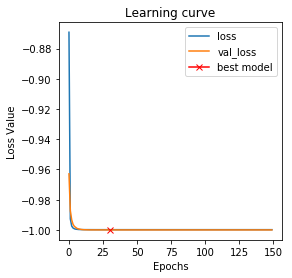

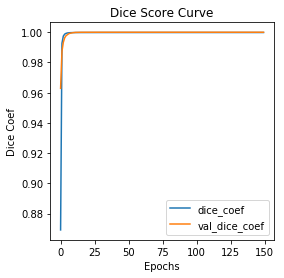

In [18]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import to_categorical
#Model parameters
base = 16
image_size = 256
img_ch = 1
batch_size =8
LR = 0.0001
SDRate = 0.5
batch_normalization = True
spatial_dropout = True
epochs = 150

#Data loader parameters
p = 0.2
path = '/Lab1/Lab3/CT/'
fold1 = 'Image'
fold2 = 'Mask'

#Data augmentation parameters
rotation_range = 10
width_shift = 0.1
height_shift_range = 0.1,
rescale = 1./255
horizontal_flip = True

#Load the data
train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)

#To one-hot-encoding
train_mask = to_categorical(train_mask, num_classes=3)
test_mask = to_categorical(test_mask, num_classes=3)

#Data augmentation
train_datagen, val_datagen = DataAugmentation(rotation_range,width_shift,height_shift_range,rescale,horizontal_flip)

#Build the multi-classification model
model = u_net_3labels(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)

#Compile the model
model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef, Recall(), Precision()] )

#Fit the data into the model
History = model.fit_generator(train_datagen.flow(train_img, train_mask,batch_size = batch_size), validation_data = val_datagen.flow(test_img, test_mask), epochs = epochs, verbose = 1)          

#Plot results
dice = True
recall = True
precision = True
plotter(History)

### Task 7

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.utils import to_categorical

#Model parameters
base = 16
image_size = 96
img_ch = 1
batch_size =4
LR = 0.0001
SDRate = 0.5
batch_normalization = True
spatial_dropout = True
epochs = 80

#Data loader parameters
p = 0.2
path = '/Lab1/Lab3/MRI/'
fold1 = 'Image'
fold2 = 'Mask'

#Data augmentation parameters
rotation_range = 10
width_shift = 0.1
height_shift_range = 0.1,
rescale = 1./255
horizontal_flip = True

#Load the data
train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size)

#Data augmentation
train_datagen, val_datagen = DataAugmentation(rotation_range,width_shift,height_shift_range,rescale,horizontal_flip)

#Build the multi-classification model
model = u_net(base,image_size, image_size, img_ch, batch_normalization, SDRate, spatial_dropout)

#Compile the model
model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef, Recall(), Precision()] )

#Fit the data into the model
History = model.fit_generator(train_datagen.flow(train_img, train_mask,batch_size = batch_size), validation_data = val_datagen.flow(test_img, test_mask), epochs = epochs, verbose = 1)          

#Plot results
dice = True
recall = True
precision = True
plotter(History)

Reading: 0/7522  of train images
Reading: 50/7522  of train images
Reading: 100/7522  of train images
Reading: 150/7522  of train images
Reading: 200/7522  of train images
Reading: 250/7522  of train images
Reading: 300/7522  of train images
Reading: 350/7522  of train images
Reading: 400/7522  of train images
Reading: 450/7522  of train images
Reading: 500/7522  of train images
Reading: 550/7522  of train images
Reading: 600/7522  of train images
Reading: 650/7522  of train images
Reading: 700/7522  of train images
Reading: 750/7522  of train images
Reading: 800/7522  of train images
Reading: 850/7522  of train images
Reading: 900/7522  of train images
Reading: 950/7522  of train images
Reading: 1000/7522  of train images
Reading: 1050/7522  of train images
Reading: 1100/7522  of train images
Reading: 1150/7522  of train images
Reading: 1200/7522  of train images
Reading: 1250/7522  of train images
Reading: 1300/7522  of train images
Reading: 1350/7522  of train images
Reading: 1400/7

Epoch 1/80
1881/1881 [==============================] - 73s 39ms/step - loss: 0.3547 - dice_coef: 0.6453 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.4733 - val_dice_coef: 0.5267 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/80
1881/1881 [==============================] - 50s 27ms/step - loss: 0.0023 - dice_coef: 0.9977 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.1254 - val_dice_coef: 0.8746 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/80
1881/1881 [==============================] - 51s 27ms/step - loss: 5.0770e-04 - dice_coef: 0.9995 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0496 - val_dice_coef: 0.9504 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/80
1881/1881 [==============================] - 51s 27ms/step - loss: 1.5493e-04 - dice_coef: 0.9998 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0262 - val_dice_coef: 0.9738 - val_recall_1: 0.0000e+00 - val_

1881/1881 [==============================] - 51s 27ms/step - loss: 2.5350e-10 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 33/80
1881/1881 [==============================] - 51s 27ms/step - loss: 6.3375e-11 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 34/80
1881/1881 [==============================] - 51s 27ms/step - loss: 2.5350e-10 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 35/80
1881/1881 [==============================] - 50s 27ms/step - loss: 1.2675e-10 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0

1881/1881 [==============================] - 49s 26ms/step - loss: 6.3375e-11 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 64/80
1881/1881 [==============================] - 48s 26ms/step - loss: 6.3375e-11 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 65/80
1881/1881 [==============================] - 48s 26ms/step - loss: 6.3375e-11 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0000e+00 - val_dice_coef: 1.0000 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 66/80
 816/1881 [============>.................] - ETA: 26s - loss: 0.0000e+00 - dice_coef: 1.0000 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00

# Bonus Task

In [11]:
##image loader for 3D

import os
import numpy as np
from random import shuffle
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def path_loader(fold1, fold2, data_path):
    #Creating data path
    image_data_path = os.path.join(data_path, fold1)   
    mask_data_path = os.path.join(data_path, fold2)
    images = []
    masks = []
    #Listing all file names in the path
    for root, dirs, files in os.walk(image_data_path):
        for name in files:
            images.append(os.path.join(image_data_path,name))
    for root2, dirs2, files2 in os.walk(mask_data_path):
        for name2 in files2:
            masks.append(os.path.join(mask_data_path,name2))
    return images, masks
    

# reading and resizing the training images with their corresponding labels
def get_train_data_shuffled(images, masks, p):
    
    c = list(zip(images, masks))

    shuffle(c)

    images, masks = zip(*c)
    
    train_x, test_x, train_y, test_y = train_test_split(images,masks,test_size = p)

    return train_x, test_x, train_y, test_y 

def data_loader(fold1, fold2, data_path, p,img_h, img_w, img_d):
    
    images, masks = path_loader(fold1, fold2, data_path)
    train_x, test_x, train_y, test_y = get_train_data_shuffled(images, masks, p)
    
    train_img = []
    train_mask = []
    test_img = []
    test_mask = []
  
    for i in range(len(train_x)):
        image_name = train_x[i]
        img = imread(image_name, as_grey=True)
        img = resize(img, (img_h, img_w, img_d), anti_aliasing = True).astype('float32')
        train_img.append([np.array(img)]) 

        if i % 50 == 0:
             print('Reading: {0}/{1}  of train images'.format(i, len(train_x)))
    for j in range(len(train_y)):
        mask_name = train_y[j]
        mask = imread(mask_name, as_grey=True)
        mask = resize(img, (img_h, img_w, img_d), anti_aliasing = True).astype('float32')
        train_mask.append([np.array(mask)])
        
    for i in range(len(test_x)):
        image_name = test_x[i]
        img = imread(image_name, as_grey=True)
        img = resize(img, (img_h, img_w, img_d), anti_aliasing = True).astype('float32')
        test_img.append([np.array(img)]) 

        if i % 50 == 0:
             print('Reading: {0}/{1}  of test images'.format(i, len(test_x)))
                
    for j in range(len(test_y)):
        mask_name = test_y[j]
        mask = imread(mask_name, as_grey=True)
        mask = resize(img, (img_h, img_w,img_d), anti_aliasing = True).astype('float32')
        test_mask.append([np.array(mask)])        
    print('finish')
 
    return train_img, train_mask, test_img, test_mask

#preprocessing
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 500.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    print(image.shape)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

# Instantiating images and labels for the model.
def get_train_test_data(fold1, fold2, data_path, p,img_h, img_w, img_d):
    
    train_img, train_mask, test_img, test_mask = data_loader(fold1, fold2, data_path, p,img_h, img_w, img_d)
    print(len(train_img))
    Train_Img = np.zeros((len(train_img), img_h, img_w, img_d), dtype = np.float32)
    Test_Img = np.zeros((len(test_img), img_h, img_w, img_d), dtype = np.float32)

    Train_Label = np.zeros((len(train_mask),img_h, img_w, img_d), dtype = np.int32)
    Test_Label = np.zeros((len(test_mask),img_h, img_w, img_d), dtype = np.int32)
    print('get train')
    for i in range(len(train_img)):
        print(i)
        Train_Img[i] = normalize(train_img[i][0])
        Train_Label[i] = normalize(train_mask[i][0])
    print(Train.Img.shape)
    
    Train_Img = np.expand_dims(Train_Img, axis = 4)  
    Train_Label = np.expand_dims(Train_Label, axis = 4) 

    for j in range(len(test_img)):
        Test_Img[j] = normalize(test_img[j][0])
        Test_Label[j] = normalize(test_mask[j][0])

    Test_Img = np.expand_dims(Test_Img, axis = 4)
    Test_Label = np.expand_dims(Test_Label, axis = 4)
   

    return Train_Img, Train_Label, Test_Img, Test_Label

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Input, Convolution3D, MaxPooling3D, Conv3DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization


def u_net3D(img_height, img_width, img_ch, img_d, batchNormalization, k_size=3):
    
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input((img_height, img_width, img_d, img_ch))
    
    #1ConvBlock
    conv1 = Convolution3D(padding='same', filters=Base, kernel_size=k_size)(data)
    if batchNormalization:
        conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    
    conv2 = Convolution3D(padding='same', filters=Base, kernel_size=k_size)(conv1)
    if batchNormalization:
        conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    
    #2ConvBlock
    conv3 = Convolution3D(padding='same', filters=Base*2, kernel_size=k_size)(pool1)
    if batchNormalization:
        conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
   
    conv4 = Convolution3D(padding='same', filters=Base*2, kernel_size=k_size)(conv3)
    if batchNormalization:
        conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    
    #3ConvBlock
    conv5 = Convolution3D(padding='same', filters=Base*4, kernel_size=k_size)(pool2)
    if batchNormalization:
        conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    
    conv6 = Convolution3D(padding='same', filters=Base*4, kernel_size=k_size)(conv5)
    if batchNormalization:
        conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)
    
    #4ConvBlock
    conv7 = Convolution3D(padding='same', filters=Base*8, kernel_size=k_size)(pool3)
    if batchNormalization:
        conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    
    conv8 = Convolution3D(padding='same', filters=Base*8, kernel_size=k_size)(conv7)
    if batchNormalization:
        conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv8)
    
    #Bottleneck
    conv9 = Convolution3D(padding='same', filters=Base*16, kernel_size=k_size)(pool4)
    if batchNormalization:
        conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    
    #Expansion
    #1ConvBlock
    up1 = Conv3DTranspose(filters= Base*8, kernel_size=(2, 2, 2),padding = 'same')(conv9)
    merged1 = concatenate([up1, conv8], axis=merge_axis)
    conv10 = Convolution3D(padding='same', filters=Base*8, kernel_size=k_size)(merged1)
    if batchNormalization:
        conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    
    conv11 = Convolution3D(padding='same', filters=Base*8, kernel_size=k_size)(conv10)
    if batchNormalization:
        conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    
    #2ConvBlock
    up2 = Conv3DTranspose(filters = Base*4, kernel_size=(2, 2, 2),padding = 'same')(conv11)
    merged2 = concatenate([up2, conv6], axis=merge_axis)
    conv12 = Convolution3D(padding='same', filters=Base*4, kernel_size=k_size)(merged2)
    if batchNormalization:
        conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)

    conv13 = Convolution3D(padding='same', filters=Base*4, kernel_size=k_size)(conv12)
    if batchNormalization:
        conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    
    #3ConvBlock
    up3 = Conv3DTranspose(filters = Base*2, kernel_size=(2, 2, 2),padding='same')(conv13)
    merged3 = concatenate([up3, conv4], axis=merge_axis)
    conv14 = Convolution3D(padding='same', filters=Base*2, kernel_size=k_size)(merged3)
    if batchNormalization:
        conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    
    conv15 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv14)
    if batchNormalization:
        conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)

    #4ConvBlock
    up4 = Conv3DTranspose(filters= Base,kernel_size=(2, 2, 2),padding ='same')(conv15)
    merged4 = concatenate([up4, conv2], axis=merge_axis)
    conv16 = Convolution3D(padding='same', filters=Base, kernel_size=k_size)(merged4)
    if batchNormalization:
        conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    
    conv17 = Convolution3D(padding='same', filters=Base, kernel_size=k_size)(conv16)
    if batchNormalization:
        conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    
    #final layer
    conv18 = Convolution3D(padding='same', filters=3, kernel_size=k_size)(merged3)
    if batchNormalization:
        conv18 = BatchNormalization()(conv18)
    output = Reshape([-1, 2])(conv18)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)

    model = Model(data, output)
    return model

In [ ]:
#training the model

image_size = 65
img_ch = 1
batch_size =8
LR = 0.0001
SDRate = 0.5
spatial_dropout = True
metric = 'dice'
epochs = 150
p = 0.2
path = '/Lab1/Lab3/CT/'
fold1 = 'Image'
fold2 = 'Mask'
base = 32
batch_normalization = True

train_img, train_mask, test_img, test_mask = get_train_test_data(fold1, fold2, path, p,image_size, image_size, image_size)
print('lol')
model = u_net3D(base,image_size, image_size, img_d, img_ch, batch_normalization, SDRate, spatial_dropout)
model.compile(optimizer = Adam(lr=LR), loss = dice_coef_loss, metrics =[dice_coef])

History = model.fit(train_img, train_mask, epochs = epochs, batch_size = batch_size, verbose = 1,
                        validation_data = (test_img,test_mask))

Reading: 0/6735  of train images
Reading: 50/6735  of train images
Reading: 100/6735  of train images
Reading: 150/6735  of train images
Reading: 200/6735  of train images
Reading: 250/6735  of train images
Reading: 300/6735  of train images
Reading: 350/6735  of train images
Reading: 400/6735  of train images
Reading: 450/6735  of train images
Reading: 500/6735  of train images
Reading: 550/6735  of train images
Reading: 600/6735  of train images
Reading: 650/6735  of train images
Reading: 700/6735  of train images
Reading: 750/6735  of train images
Reading: 800/6735  of train images
Reading: 850/6735  of train images
Reading: 900/6735  of train images
Reading: 950/6735  of train images
Reading: 1000/6735  of train images
Reading: 1050/6735  of train images
Reading: 1100/6735  of train images
Reading: 1150/6735  of train images
Reading: 1200/6735  of train images
Reading: 1250/6735  of train images
Reading: 1300/6735  of train images
Reading: 1350/6735  of train images
Reading: 1400/6